# Chapter 2 -- Build and train a very simple neural network with backpropagation

In this notebook, we will build, and train the very simple neural network featured in Chapter 2 of **[The StatQuest Illustrated Guide to Neural Networks and AI](https://www.amazon.com/dp/B0DRS71QVQ)**. We'll start with the untrained **Weights** and **Biases**, as seen in the figure below.

<img src="https://github.com/StatQuest/signa/blob/main/chapter_02/images/chapter_2_train_all.png?raw=1" alt="an untrained neural network" style="width: 800px;">

Then train them with **Backpropagation** to get the trained Weights and Biases seen in the figure below.

<img src="https://github.com/StatQuest/signa/blob/main/chapter_02/images/chapter_1_pre_trained_nn_labeled.png?raw=1" alt="a trained neural network" style="width: 800px;">

In this tutorial, we will:

- **Code a neural network with untrained weights and biases**. This will show the basic structure of a class that inherits from [`LightningModule` to build a neural network](https://lightning.ai/docs/pytorch/stable/).
- **Train the weights and biases in our neural network**. This will show how to train the weights and biases in a simple neural network.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
# see https://docs.pytorch.org/docs/stable/generated/torch.optim.SGD.html
# SGD is short of Stochastic Gradient Descent, but
# the way we'll use it, passing in all of the training
# data at once instead of passing it random subsets,
# it will act just like plain old Gradient Descent.

import lightning as L  ## Lightning makes it easier to write, optimize and scale code
from torch.utils.data import TensorDataset, DataLoader
## We'll store our data in DataLoaders. See explanations below.

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"]= (2,2)

*PyTorch* is the foundational deep learning framework. It provides the fundamental tools to build and define neural networks, like tensors and layers.

*PyTorch Lightning* is a high-level wrapper built on top of PyTorch. It's not a replacement; it's a way to **organize** the PyTorch code and remove boilerplate. It enforces a clean structure using the `LightningModule`. This class organizes the code into clear, dedicated methods:

_ `__init__()` & `forward()`: define the model layers (just like in pure PyTorch).
- `training_step()`: what happens for one batch of training.
- `validation_step()`: what happens for one batch of validation.
- `test_step()`: what happens for one batch of testing.
- `configure_optimizers()`: where we return our optimizer (e.g., Adam).

## Create the Training Dataset

In Chapter 2, we had a very simple dataset that consisted of three points, as seen in the figure below.

<img src="https://github.com/StatQuest/signa/blob/main/chapter_02/images/chapter_2_training_data.png?raw=1" alt="a simple dataset for training" style="width: 800px;">

Although it's not required, we're going to put our training data into a `DataLoader`. This will offer a lot of features, for example, if we had a large dataset, a `DataLoader` gives us an easy way to access the data in batches instead of all at once. This is critical when we have more data than RAM to store it in. A DataLoader can also shuffle the data for us each epoch and makes it easy to only use a fraction of the data if we want to do a quick and rough training for debugging purposes.

In [2]:
# The inputs are the x-axis coordinates for each data point
# These values represent different doses
training_inputs = torch.tensor([0.0, 0.5, 1.0])

# The labels are the y-axis coordinates for each data point
# These values represent the effectiveness
training_labels = torch.tensor([0.0, 1.0, 0.0])

# Now let's package everything up into a DataLoader
training_dataset = TensorDataset(training_inputs, training_labels)
dataloader = DataLoader(training_dataset)  # Feed with a tuple of tensors

In [3]:
print(training_dataset.tensors)

(tensor([0.0000, 0.5000, 1.0000]), tensor([0., 1., 0.]))


## Create a Neural Network

Now we'll build a neural network that has trainable Weights and Biases.

For this, we'll use `L.LightningModule`, which has everything `nn.Module` has, plus we can define the optimizer we want to use as well as tell PyTorch how each training step should work.

In [4]:
class myNN(L.LightningModule):  # We don't henerit from `nn.Module` like in Chapter 1.

    def __init__(self):
        super().__init__()

        """
        Create all of the weights and biases for the network.
        However, this time they are initialized with *random values*.

        We are also wrapping the tensors up in `nn.Parameter()`
        objects, instead of just tensor, like previously , for example
        in `self.w1 = torch.tensor(1.43)`. PyTorch will only optimize 
        parameters. There are a lot of different ways to create parameters,
        and we'll see those in later examples, but `nn.Parameter()` is 
        the most basic.
        """

        self.w1 = nn.Parameter(torch.tensor(0.06))
        self.b1 = nn.Parameter(torch.tensor(0.0))

        self.w2 = nn.Parameter(torch.tensor(3.49))
        self.b2 = nn.Parameter(torch.tensor(0.0))

        self.w3 = nn.Parameter(torch.tensor(-4.11))
        self.w4 = nn.Parameter(torch.tensor(2.74))

        self.loss = nn.MSELoss(reduction='sum')  # SSR


    def forward(self, input_values):  # Identical to what we used in Chapter 1.

        top_x_axis_values = (input_values * self.w1) + self.b1
        bottom_x_axis_values = (input_values * self.w2) + self.b2

        top_y_axis_values = F.relu(top_x_axis_values)
        bottom_y_axis_values = F.relu(bottom_x_axis_values)

        output_values = (top_y_axis_values * self.w3) + (bottom_y_axis_values * self.w4)

        return output_values


    def configure_optimizers(self):  # Configures optimizer to use for backpropagation.

        """
        PyTorch doesn't have a Gradient Descent optimizer (see page 51), but a
        Stochastic Gradient Descent (SGD) optimizer, that uses randoms subsets of 
        data. However, since we are running only 3 doses through the NN each time, 
        rather than a random subset, we are essentially doing Gradient Descent.
        """

        return SGD(self.parameters(), lr=0.01)


    def training_step(self, batch):  # Take a step during gradient descent.
        
        inputs, labels = batch  # Collect input
        outputs = self.forward(inputs)  # Run input through the neural network
        loss = self.loss(outputs, labels)

        """
        the `loss` quantifies the difference between the observed drug effectiveness
        in `labels` and the outputs created by the neural network.
        """

        return loss

PyTorch Lightning operates on a principle of "convention over configuration." It expects us to define specific methods with particular names in the `LightningModule`, and it will automatically call them at the correct time during the training, validation, and testing loops.

The `training_step` method is one of these required, conventional methods for training.

In [5]:
model = myNN()  # Make model from the class

# Now print out the name and value for each named parameter parameter in the model. 
# Remember parameters are variables, like Weights and Biases, that we can train.

for name, param in model.named_parameters():
    print(name, torch.round(param.data, decimals=2))

w1 tensor(0.0600)
b1 tensor(0.)
w2 tensor(3.4900)
b2 tensor(0.)
w3 tensor(-4.1100)
w4 tensor(2.7400)


In [6]:
list(model.parameters())

[Parameter containing:
 tensor(0.0600, requires_grad=True),
 Parameter containing:
 tensor(0., requires_grad=True),
 Parameter containing:
 tensor(3.4900, requires_grad=True),
 Parameter containing:
 tensor(0., requires_grad=True),
 Parameter containing:
 tensor(-4.1100, requires_grad=True),
 Parameter containing:
 tensor(2.7400, requires_grad=True)]

In [7]:
print("Model:", model)

Model: myNN(
  (loss): MSELoss()
)


In [8]:
# Run different doses through the neural network through `forward`
output_values = model(training_inputs)

print("Output from the initialized NN:")
print(torch.round(output_values))

Output from the initialized NN:
tensor([0., 5., 9.], grad_fn=<RoundBackward0>)


## Plot of the initial model

We successfully ran the doses from the training data through the model. However, the output from the model is way different than we expect (we expected 0.0, 1.0, and 0.0). So let's draw a picture of the bent shape that the model uses to make predictions and compare that to the training data.

In [9]:
# Create the different doses we want to run through the neural network.
# torch.linspace() creates the sequence of numbers between, and including, 0 and 1.
input_doses = torch.linspace(start=0, end=1, steps=11)

# Print out the doses to make sure they are what we expect
print("Input dose values:", input_doses)

Input dose values: tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000, 1.0000])


In [10]:
output_values = model(input_doses)
print("Output predicted effectiveness:", output_values)

Output predicted effectiveness: tensor([0.0000, 0.9316, 1.8632, 2.7948, 3.7264, 4.6580, 5.5896, 6.5212, 7.4528,
        8.3844, 9.3160], grad_fn=<AddBackward0>)


Now draw a graph that shows how well, or poorly, the model predicts the training data. At this point, since the model is untrained, there should be a big difference between the model's output and the training data.

Note that every tensor that has `requires_grad=True` (like the current model) is part of a graph. PyTorch records every operation (addition, multiplication, etc.) involving this tensor. Libraries like Seaborn, Matplotlib, and NumPy have no concept of this computational graph. They are external libraries that expect simple data, like a Python number or a NumPy array, not a "live" PyTorch tensor that's actively tracking operations. That's why here we must first "detach" it from the computational graph.

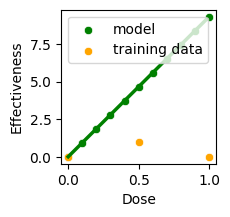

In [11]:
# First, draw the individual output points
sns.scatterplot(
    x=input_doses,
    # y=output_values.detach().numpy(),
    y=output_values.detach(),
    color='green',
    label='model',
)

# Now connect those points with a line
sns.lineplot(
    x=input_doses,
    y=output_values.detach(),
    color='green',
    linewidth=2.5)

# Add the values in the training dataset
sns.scatterplot(
    x=training_inputs,
    y=training_labels,
    color='orange',
    label='training data')

# now label the y- and x-axes.
plt.ylabel('Effectiveness')
plt.xlabel('Dose')
plt.legend();

We see how badly the bent shape fits the training data, so let's train the model.

## Training the Weights and Biases

Training consists of creating a **Lightning Trainer** with `L.Trainer()` and then calling the `fit()` method on the our model with the training data.

In [12]:
trainer = L.Trainer(
    max_epochs=500,  # How many times to go through the training data
    logger=False,
    enable_checkpointing=False,
    enable_progress_bar=False)

trainer.fit(model, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | loss         | MSELoss | 0      | train
  | other params | n/a     | 6      | n/a  
-------------------------------------------------
6         Trainable params
0         Non-trainable params
6         Total params
0.000     Total estimated model params size (MB)
1         Modules in train mode
0         Modules in eval mode
c:\Users\Sébastien\Documents\data_science\machine_learning\statsquest_neural_networks\.env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
`Trainer.fit` stopped: `max_epochs=500` reached.


When we use a PyTorch Lightning `Trainer` to train our model, the `Trainer` executes a pre-defined, optimized training loop. Here's a simplified breakdown of what the `Trainer` does automatically behind the scenes for each batch of data:

1.  **Fetches a Batch:** the `Trainer` gets a batch of data from the data loader. In the current example, it takes all 3 data points.
2.  **Calls `training_step`:** it passes this batch to our model's `training_step(self, batch)` method. Remind here that the method returns `loss`.
3.  **Receives the Loss:** the `Trainer` require that the `training_step` method returns a single tensor representing the calculated loss.
4.  **Automatic Backpropagation:** once the `Trainer` receives the `loss` tensor from the defined `training_step`, it automatically performs the backpropagation process:
    - Calling `loss.backward()` to compute the gradients of the loss with respect to all of our model's parameters (the `nn.Parameter` objects like `self.w1`, `self.b1`, etc.).
    - Calling `optimizer.step()` to update the parameters based on the computed gradients and the learning rate. The optimizer itself is what we defined in the `configure_optimizers` method.
    - Calling `optimizer.zero_grad()` to reset the gradients for the next iteration.

In [13]:
# Now that we've trained the model, let's print out the new values for each Weight and Bias.
for name, param in model.named_parameters():
    print(name, torch.round(param.data, decimals=3))

w1 tensor(1.4790)
b1 tensor(-0.5680)
w2 tensor(2.6980)
b2 tensor(-0.2580)
w3 tensor(-4.2400)
w4 tensor(1.5830)


Lastly, let's draw a graph of the bent shape that the model is using for predictions and compare it to the training data. In theory, the bent shape should fit the data much better now that we have optimized the Weights and Biases.

In [14]:
# Run the different doses through the trained neural network.
output_values_trained = model(input_doses)

print(
    "Output predicted effectiveness (after training):",
    torch.round(output_values_trained, decimals=2))

Output predicted effectiveness (after training): tensor([0.0000, 0.0200, 0.4500, 0.8700, 1.2000, 1.0000, 0.8000, 0.6000, 0.4000,
        0.2000, 0.0000], grad_fn=<RoundBackward1>)


Now draw a graph that shows how well, or poorly, the model predicts the training data. At this point, since we just trained the model, the training data should overlap the model's output

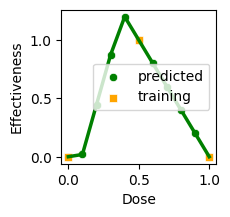

In [15]:
# First, draw the individual output points
sns.scatterplot(
    x=input_doses,
    y=output_values_trained.detach(),
    color='green',
    label='predicted',
    )

# Now connect those points with a line
sns.lineplot(
    x=input_doses,
    y=output_values_trained.detach(),
    color='green',
    linewidth=2.5)

# Add the values in the training dataset
sns.scatterplot(
    x=training_inputs,
    y=training_labels,
    color='orange',
    marker='s',
    label='training'
    )

# Now label the y- and x-axes
plt.ylabel('Effectiveness')
plt.xlabel('Dose')
plt.legend();